In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

## Catfish Sales Data

In [3]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [4]:
#read data
catfish_sales = pd.read_csv('Sample Data/catfish.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

/var/folders/nc/lzp_t3zn1m5_9jr25f_8fqj00000gn/T/ipykernel_2056/2772518632.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  catfish_sales = pd.read_csv('Sample Data/catfish.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


In [5]:
#infer the frequency of the data
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

In [7]:
start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

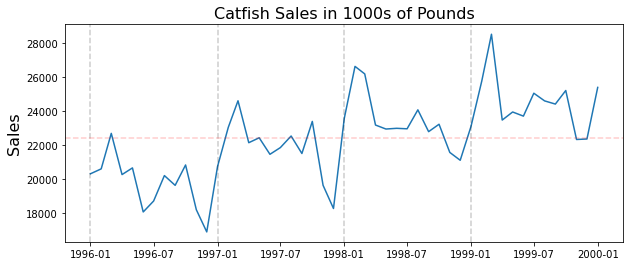

In [8]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=16)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(lim_catfish_sales.mean(), color='r', alpha=0.2, linestyle='--')
# upwards trend가 존재함을 확인 가능

## Remove the trend

In [9]:
first_diff = lim_catfish_sales.diff()[1:]

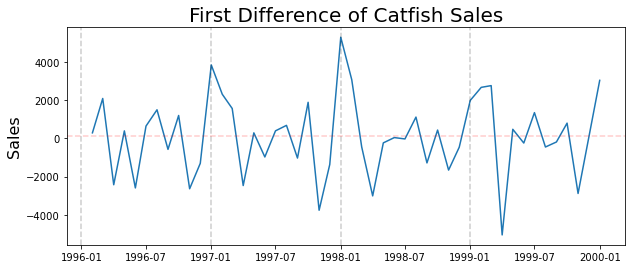

In [10]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('First Difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(first_diff.mean(), color='r', alpha=0.2, linestyle='--')

> 평균은 0으로 수렴했지만, 계절성이 있음을 확인할 수 있음

## ACF

<BarContainer object of 17 artists>

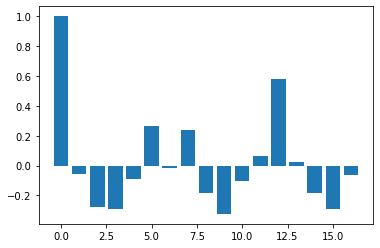

In [20]:
acf_vals = acf(first_diff)
num_lags = 17
plt.bar(range(num_lags), acf_vals[:num_lags])
# plot_acf = plot_acf(first_diff)


> Based on ACF, we should start with a seasonal MA process

## PACF

<BarContainer object of 15 artists>

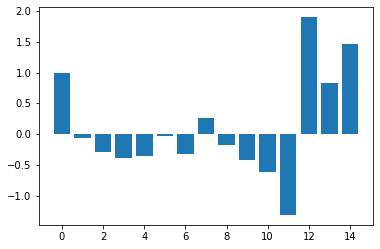

In [21]:
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])
# plot_acf = plot_pacf(first_diff, lags=20)

> Based on PACF, we should start with a seasonal AR process

## Get training and testing sets

In [35]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

train_data = lim_catfish_sales[:train_end]
test_data = lim_catfish_sales[train_end + timedelta(days=1):test_end]

## Fit the SARMA model

In [36]:
my_order = (0, 1, 0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [37]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.23278D+00    |proj g|=  2.33070D+00

At iterate    5    f=  8.52629D+00    |proj g|=  1.37493D-01

At iterate   10    f=  8.50821D+00    |proj g|=  1.57262D-03

At iterate   15    f=  8.50821D+00    |proj g|=  2.63922D-04

At iterate   20    f=  8.50817D+00    |proj g|=  1.30178D-03

At iterate   25    f=  8.50579D+00    |proj g|=  7.81541D-03

At iterate   30    f=  8.50313D+00    |proj g|=  1.60483D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/Yunhee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/Yunhee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


In [38]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                   43
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -365.635
Date:                              Wed, 26 Jul 2023   AIC                            737.269
Time:                                      07:50:13   BIC                            742.482
Sample:                                  01-01-1996   HQIC                           739.180
                                       - 07-01-1999                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8250      0.120      6.848      0.000       0.589       1.061
ma.S.L12      -0.51

## Prediction

In [39]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

Text(0, 0.5, 'Error')

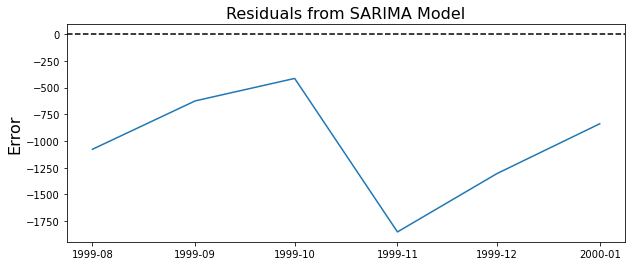

In [40]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=16)
plt.ylabel('Error', fontsize=16)

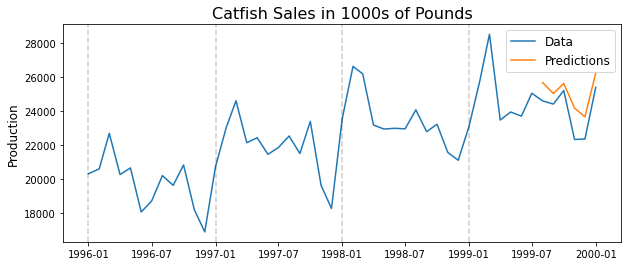

In [41]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=12)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=16)
plt.ylabel('Production', fontsize=12)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [42]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0433


In [43]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1122.307963670559


## Using the Rolling Forecast Origin

In [44]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_catfish_sales[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

/Users/Yunhee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/Yunhee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.
/Users/Yunhee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.
/Users/Yunhee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.23278D+00    |proj g|=  2.33070D+00

At iterate    5    f=  8.52629D+00    |proj g|=  1.37493D-01

At iterate   10    f=  8.50821D+00    |proj g|=  1.57262D-03

At iterate   15    f=  8.50821D+00    |proj g|=  2.63922D-04

At iterate   20    f=  8.50817D+00    |proj g|=  1.30178D-03

At iterate   25    f=  8.50579D+00    |proj g|=  7.81541D-03

At iterate   30    f=  8.50313D+00    |proj g|=  1.60483D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
/Users/Yunhee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate    5    f=  8.54088D+00    |proj g|=  1.48353D-02

At iterate   10    f=  8.54080D+00    |proj g|=  5.63754D-03

At iterate   15    f=  8.53493D+00    |proj g|=  1.22541D-01

At iterate   20    f=  8.49428D+00    |proj g|=  7.02953D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     32      1     0     0   3.605D-05   8.494D+00
  F =   8.4942658980669918     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

/Users/Yunhee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/Yunhee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.
/Users/Yunhee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.93096D+00    |proj g|=  1.46578D+00

At iterate    5    f=  8.52823D+00    |proj g|=  1.98734D-01

At iterate   10    f=  8.51339D+00    |proj g|=  1.50669D-03

At iterate   15    f=  8.51339D+00    |proj g|=  7.61903D-04

At iterate   20    f=  8.51334D+00    |proj g|=  2.50668D-02

At iterate   25    f=  8.50917D+00    |proj g|=  8.46551D-02

At iterate   30    f=  8.48985D+00    |proj g|=  1.94199D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

In [45]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

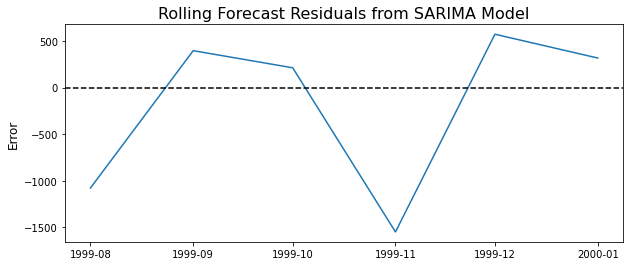

In [46]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=16)
plt.ylabel('Error', fontsize=12)

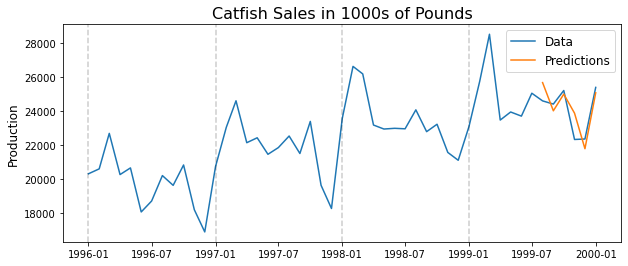

In [48]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=12)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=16)
plt.ylabel('Production', fontsize=12)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [49]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0293


In [50]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 835.7364284337096
